In [1]:
# Simon Dudtschak
# 20166103
#
# Based on: SOM-CNN by Ashraf Neisari
# Available: https://github.com/Ashsari/spam_review_detection

In [61]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import random
import time

from preprocessing import Preprocessing
from Clustering_words_SOM import Clustering
from Constructing_images_classification import Classify
import matplotlib.pyplot as plt

from SRD_minisom import MiniSom

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import collections
from itertools import chain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
rand = random.randint(0,10000)
np.random.seed(rand)
random.seed(rand)

globalTime = time.perf_counter()

In [63]:
##############################################################
##                      PRE-PROCESSING                      ##
##############################################################
print("\nPRE-PROCESSING\n")

#importing the dataset
#@EXTENSION
dataset = pd.read_csv('final_mfrc_data.csv')
reviews = dataset.iloc[:,0]

#get labels and convert them to categorical format
list_words = []
for row in dataset["annotation"]:
    words = row.split(',')
    word_counts = collections.Counter(words)
    list_words.append(words)
    flat_list = list(chain.from_iterable(list_words))
unique_words = set(flat_list)


PRE-PROCESSING



In [64]:
#get labels and convert them to categorical format
y = dataset.iloc[:,3]
le = LabelEncoder()
y = le.fit_transform(y)
label = to_categorical(y, num_classes = 6)

In [65]:
#cleaning the vocabulary and tokenizing the reviews
print("Cleaning")
vocabulary, numWords, review_vocab, cleaned_reviews = Preprocessing.cleaning_reviews(reviews)

# keeping only unique words     
vocabulary = list(set(vocabulary))

# Here we provide the pretrained word embedding dictionary of glove with the vector dimension of 300
embedding_dim = 300
filepath ='glove.6B.300d.txt'

Cleaning


In [7]:
#calculate the TF-IDF of the vocabularies from the cleaned reviews 
df_TF_IDF, missed_tfidfW = Preprocessing.words_frequency(cleaned_reviews, vocabulary)

c:\users\simon\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
#Here we construct the embedding matrix of the fetched vocabulary from the reviews. 
#Each row of the matrix represents the corresponding word embedding vector
print("Embedding")
embedding_matrix = Preprocessing.create_embedding_matrix(filepath, vocabulary, embedding_dim )

#We fetch the list of the words that are not covered by the pretrained dictionary and later eliminate them from the vocabulary list  
nonzero_elements, not_foundWords, not_foundIndex = Preprocessing.not_found_words(embedding_matrix, vocabulary)


Embedding
The percentage of the covered words in the pretrained dictionary:  0.8740046287216099
number of not found words is:  3212


In [9]:
# Feature scaling make all features(the vectors values) between 0 and 1
print("Scaling")
X = embedding_matrix
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

Scaling


In [66]:
X.shape

(25493, 300)

In [67]:
dX = []

for i, item in enumerate(X):
    annotations = dataset['annotation'][i].split(',')
    tail = []
    for ann in unique_words:
        if ann in annotations: tail.append(1)
        else: tail.append(0)
    item = np.append(item,tail)
    dX.append(item)
        

In [68]:
dX = np.array(dX)
dX.shape
dX[1]

array([0.49649053, 0.67231545, 0.47524148, 0.62839463, 0.60043299,
       0.41949039, 0.42957941, 0.54067784, 0.44353142, 0.34783921,
       0.49041225, 0.33435842, 0.50754154, 0.52678723, 0.57563587,
       0.68442078, 0.56466101, 0.4599754 , 0.43290902, 0.68867693,
       0.56125129, 0.26339586, 0.56553905, 0.3349208 , 0.51264192,
       0.47986341, 0.55910836, 0.36430976, 0.54947658, 0.6005    ,
       0.74362882, 0.66306559, 0.45817368, 0.50257421, 0.3784458 ,
       0.31370048, 0.39767151, 0.53020044, 0.50894197, 0.72852639,
       0.403044  , 0.53532374, 0.5479201 , 0.56870529, 0.47293567,
       0.40616924, 0.48596852, 0.41806685, 0.61406825, 0.42184647,
       0.63677303, 0.43649591, 0.43641701, 0.70000322, 0.64175415,
       0.49531865, 0.36495563, 0.62003231, 0.51129567, 0.63049151,
       0.45948083, 0.44163038, 0.36995371, 0.40074689, 0.18166129,
       0.50834947, 0.6519879 , 0.33711973, 0.61525565, 0.53010772,
       0.68701145, 0.42947979, 0.57020868, 0.52848988, 0.50875

In [34]:
##########################################################
##                      CLUSTERING                      ##
##########################################################
print("\nCLUSTERING\n")


#define the grid size for the SOM map by g.
#@EXTENSION
g = 60
X_of_map = g
y_of_map = g

#the input length passed to the SOM is the embedding vectors dimension 
input_len = X.shape[1]

#defining the neghborhood radius sigma as s and the learning rate
s = 1 
l = 0.1 # the radius

#We create a SOM object and train it on the word vectors that were prepared in the pre-processing step
som = MiniSom(x = X_of_map, y= y_of_map, input_len = input_len, sigma = s, learning_rate = l, random_seed = 8)
#Randomly initialize the weights that are assigne to each grid cells
som.random_weights_init(X)

#trining the SOM
print("SOM Training")
#@EXTENSION
som.train_batch(data = X, num_iteration = 1000)



# #separating ham and spam reviews from in the dataset
# print("Seperate")
# ham , spam = Clustering.separate_ham_spam(reviews, y)
# #getting vocabulary list that are used in ham and spam reviews

# print("Cleaning")
# vocabulary_ham, numWords_ham, review_vocab_ham, cleaned_reviews_ham = Preprocessing.cleaning_reviews(ham)
# vocabulary_spam, numWords_spam, review_vocab_spam, cleaned_reviews_spam = Preprocessing.cleaning_reviews(spam)
# vocabulary_ham = list(set(vocabulary_ham))
# vocabulary_spam = list(set(vocabulary_spam))

# #creating a list of words that are common among the ham and spam reviews
# matches = list(set(vocabulary_spam) & set(vocabulary_ham))


CLUSTERING

SOM Training


In [36]:
#fetching the winning nodes of the word vectors from the SOM grid map
print("Calculate Win Map")
mappings = som.win_map(X)

Calculate Win Map


In [37]:
##############################################################
##                      CLASSIFICATION                      ##
##############################################################
print("\nCLASSIFICATION\n")

#mappings = som.win_map(X)
map_cells = Classify.words_win_cel(mappings, vocabulary) 

#constructing the review images based on the feature word density
print("Create Density Image")
dense_img = Classify.create_dens_img(review_vocab, map_cells, vocabulary, not_foundWords, X_of_map, y_of_map)


CLASSIFICATION

Create Density Image


In [38]:
#constructing the review images based on the feature word frequency 
print("Create Frequency Image")
frequency_img= Classify.create_freq_img(review_vocab, map_cells, vocabulary, missed_tfidfW, not_foundWords, X_of_map, y_of_map, df_TF_IDF)    


#reshaping the images to make them ready for the CNN
review_images = Classify.reshape_img(dense_img, frequency_img) 


Create Frequency Image


In [85]:


#splitting the data to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(review_images ,label, test_size=0.2,random_state= 252)
X_trainx, X_testx, y_trainx, y_testx = train_test_split(review_images[:20] ,label[:20], test_size=0.2,random_state= 252)
print("Create Model")
model = Classify.create_model(g, X_train, y_train, X_test, y_test)

model_x = Classify.create_model(g, X_train, y_train, X_test, y_test)

Create Model
Model Done
Model Done


In [86]:
history_x = model_x.fit(X_trainx, y_trainx, validation_data =(X_testx, y_testx), verbose = 1, epochs = 1, batch_size=10)

2/2 [==============================] - 1s 207ms/step - loss: 0.6901 - accuracy: 0.0625 - val_loss: 0.6596 - val_accuracy: 0.0000e+00


In [88]:
from tensorflow.keras.callbacks import EarlyStopping
#monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 10, verbose =1, mode = 'auto')

print("Training")
history = model.fit(X_train, y_train, validation_data =(X_test, y_test), verbose = 1, epochs =50 , batch_size = 50)
#history = model.fit(X_train, y_train, validation_data =(X_test, y_test), callbacks = [monitor], verbose = 1, epochs =40 , batch_size = 20)

Training
Epoch 1/50
980/980 [==============================] - 176s 179ms/step - loss: 0.4378 - accuracy: 0.2009 - val_loss: 0.4294 - val_accuracy: 0.2135
Epoch 2/50
980/980 [==============================] - 174s 177ms/step - loss: 0.4310 - accuracy: 0.2109 - val_loss: 0.4279 - val_accuracy: 0.2097
Epoch 3/50
980/980 [==============================] - 171s 175ms/step - loss: 0.4288 - accuracy: 0.2243 - val_loss: 0.4279 - val_accuracy: 0.2166
Epoch 4/50
980/980 [==============================] - 171s 175ms/step - loss: 0.4271 - accuracy: 0.2340 - val_loss: 0.4289 - val_accuracy: 0.2073
Epoch 5/50
980/980 [==============================] - 171s 175ms/step - loss: 0.4259 - accuracy: 0.2353 - val_loss: 0.4300 - val_accuracy: 0.1930
Epoch 6/50
980/980 [==============================] - 169s 172ms/step - loss: 0.4249 - accuracy: 0.2416 - val_loss: 0.4303 - val_accuracy: 0.1980
Epoch 7/50
980/980 [==============================] - 168s 171ms/step - loss: 0.4238 - accuracy: 0.2437 - val_loss:

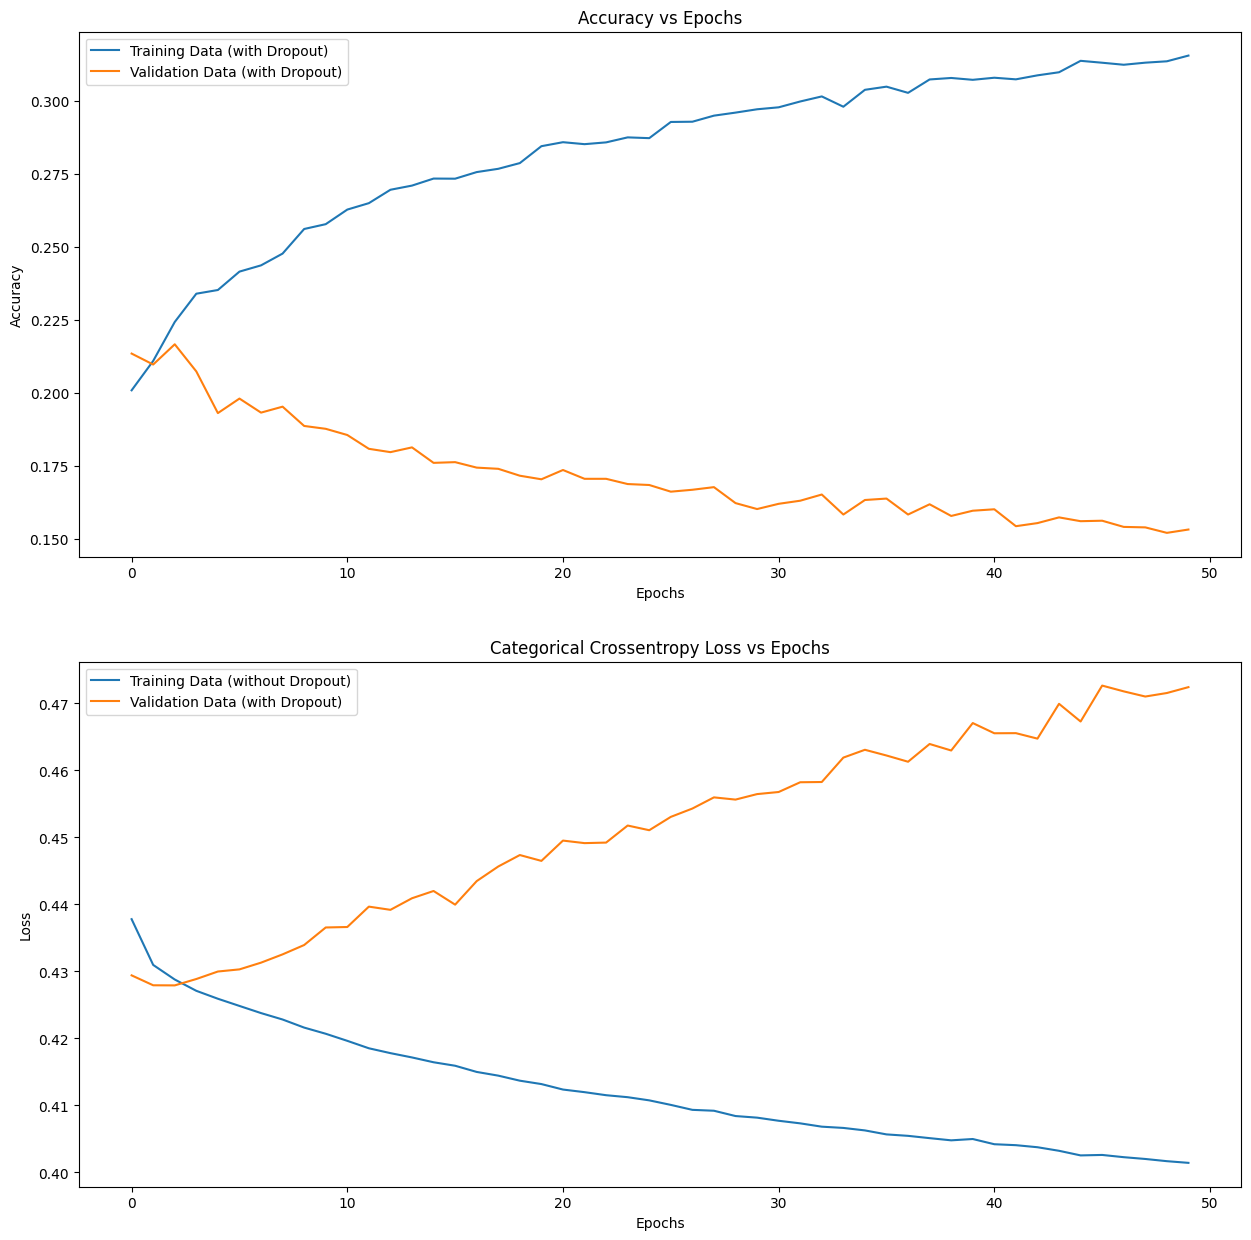

In [89]:
# Plot
figure, axis = plt.subplots(2, 1, figsize=(15,15))

axis.ravel()

axis[0].plot(history.history['accuracy'],label='Training Data (with Dropout)')
axis[0].plot(history.history['val_accuracy'], label='Validation Data (with Dropout)')

axis[0].set(xlabel='Epochs',ylabel='Accuracy', title='Accuracy vs Epochs')
axis[0].legend(loc="upper left")

plt.savefig('acc_vs_epoch.png')

axis[1].plot(history.history['loss'], label='Training Data (without Dropout)')
axis[1].plot(history.history['val_loss'], label='Validation Data (with Dropout)')


axis[1].set(xlabel='Epochs',ylabel='Loss', title='Categorical Crossentropy Loss vs Epochs')
axis[1].legend(loc="upper left")

plt.savefig('loss_vs_epoch.png')

plt.show()

Training Accuracy: 0.3403
Testing Accuracy:  0.1531


383/383 [==============================] - 14s 37ms/step
              precision    recall  f1-score   support

           0       0.19      0.95      0.32      2339
           1       0.05      0.00      0.01      2455
           2       0.03      0.00      0.00      2321
           3       0.07      0.00      0.01      2445
           4       0.04      0.00      0.00      2414
           5       0.00      0.00      0.00       272

    accuracy                           0.18     12246
   macro avg       0.06      0.16      0.06     12246
weighted avg       0.07      0.18      0.06     12246

Total =  4630
[[2223   44   24   23   19    6]
 [2355    8   32   33   18    9]
 [2221   29    3   39   14   15]
 [2351   32   27    9   15   11]
 [2313   36   26   26    3   10]
 [ 264    4    1    1    2    0]] 

hams  P =  2267
TP =  2223
FN =  44
tp_rate tp/p :  0.9805910895456551 

Spams N =  2363
TN =  8
FP =  2355
fp_rate fp/N :  0.99661

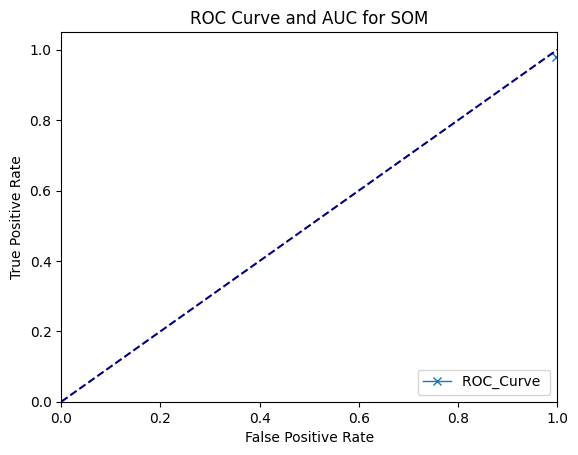

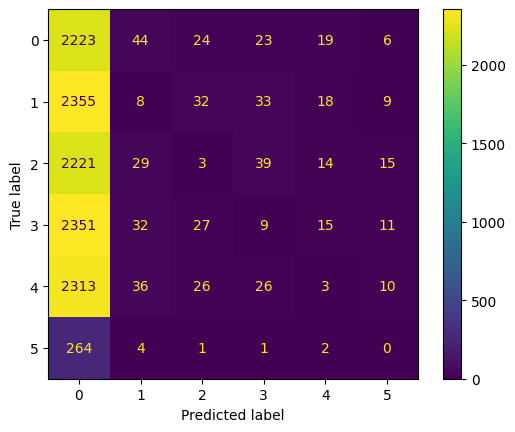

In [90]:
#getting the evaluation performance of the model
loss, tr_accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(tr_accuracy)) # 
loss, te_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(te_accuracy)) # 
print('\n')

pred = (model.predict(X_test) > 0.5).astype("int32")
predict_classes = np.argmax(pred, axis=1)
expected_classes = np.argmax(y_test, axis = 1)
#print the classification report
evaluation = classification_report(expected_classes, predict_classes)
print(evaluation)

#plotting ROC value of the result
matrix = confusion_matrix(expected_classes, predict_classes)
ROC_value, fprx, tpry = Classify.ROC_Val(matrix)

globalTime = time.perf_counter() - globalTime
print("Total Time: ", globalTime)

confusion_matrix(expected_classes, predict_classes)
import sklearn

sklearn.metrics.ConfusionMatrixDisplay(matrix).plot()

Training Accuracy: 0.1907
Testing Accuracy:  0.1961


383/383 [==============================] - 20s 51ms/step
              precision    recall  f1-score   support

           0       0.19      1.00      0.32      2339
           1       0.00      0.00      0.00      2455
           2       0.00      0.00      0.00      2321
           3       0.00      0.00      0.00      2445
           4       0.00      0.00      0.00      2414
           5       0.00      0.00      0.00       272

    accuracy                           0.19     12246
   macro avg       0.03      0.17      0.05     12246
weighted avg       0.04      0.19      0.06     12246

Total =  4794
[[2339    0    0    0    0    0]
 [2455    0    0    0    0    0]
 [2321    0    0    0    0    0]
 [2445    0    0    0    0    0]
 [2414    0    0    0    0    0]
 [ 272    0    0    0    0    0]] 

hams  P =  2339
TP =  2339
FN =  0
tp_rate tp/p :  1.0 

Spams N =  2455
TN =  0
FP =  2455
fp_rate fp/N :  1.0 

ROC_value :  1.0 

c:\users\simon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\simon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\simon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Total Time:  686.2970306999996


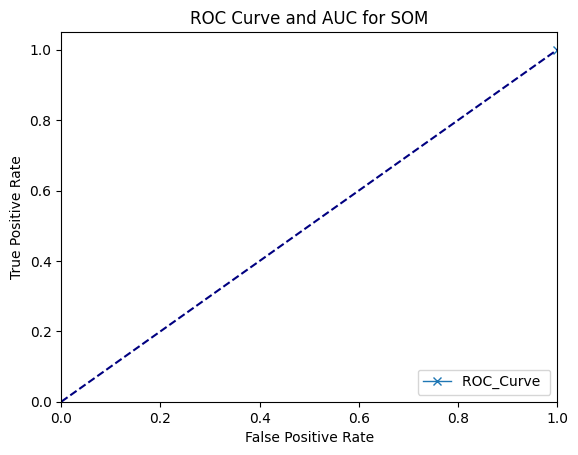

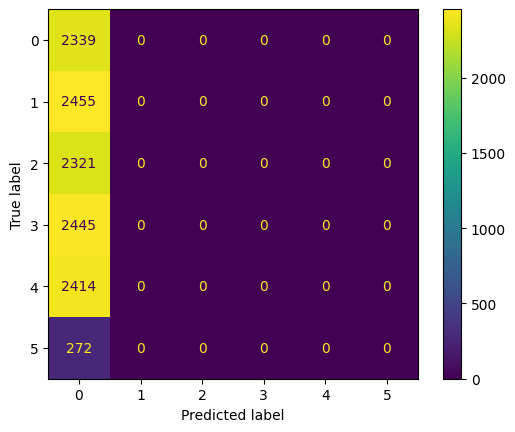

In [87]:
#getting the evaluation performance of the model_x
loss, tr_accuracy = model_x.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(tr_accuracy)) # 
loss, te_accuracy = model_x.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(te_accuracy)) # 
print('\n')

pred = (model_x.predict(X_test) > 0.5).astype("int32")
predict_classes = np.argmax(pred, axis=1)
expected_classes = np.argmax(y_test, axis = 1)
#print the classification report
evaluation = classification_report(expected_classes, predict_classes)
print(evaluation)

#plotting ROC value of the result
matrix = confusion_matrix(expected_classes, predict_classes)
ROC_value, fprx, tpry = Classify.ROC_Val(matrix)

globalTime = time.perf_counter() - globalTime
print("Total Time: ", globalTime)

confusion_matrix(expected_classes, predict_classes)
import sklearn

sklearn.metrics.ConfusionMatrixDisplay(matrix).plot()